In [1]:
!python -m venv myenv
!source myenv/bin/activate

In [22]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install BeautifulSoup4
!pip install requests
!pip install numpy==1.26.4
!pip install joblib



In [3]:
!pip install lxml

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
dataset = pd.read_csv('website_classification.csv')
dataset.shape

(1408, 4)

In [7]:
df = dataset[['website_url', 'cleaned_website_text', 'Category']].copy()
df['Category'].value_counts()

Category
Education                          114
Business/Corporate                 109
Travel                             107
Streaming Services                 105
Sports                             104
E-Commerce                         102
Games                               98
News                                96
Health and Fitness                  96
Computers and Technology            93
Photography                         93
Food                                92
Law and Government                  84
Social Networking and Messaging     83
Forums                              16
Adult                               16
Name: count, dtype: int64

In [8]:
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates()

category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.cleaned_website_text).toarray()
labels = df.category_id

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics

X = df['cleaned_website_text']

X_train, X_test, y_train, y_test = train_test_split(X, df['category_id'], 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

m = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)
m1=CalibratedClassifierCV(estimator=m,
                                        cv="prefit").fit(tfidf_vectorizer_vectors, y_train)

In [12]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [13]:
import spacy
print(spacy.__version__)

3.7.5


In [14]:
from collections import Counter
spacy.prefer_gpu()
import en_core_web_sm
#anconda prompt ko run as adminstrator and copy paste this:python -m spacy download en
nlp = en_core_web_sm.load()
import re
def clean_text(doc):
    '''
    Clean the document. Remove pronouns, stopwords, lemmatize the words and lowercase them
    '''
    doc = nlp(doc)
    tokens = []
    exclusion_list = ["nan"]
    for token in doc:
        if token.is_stop or token.is_punct or token.text.isnumeric() or (token.text.isalnum()==False) or token.text in exclusion_list :
            continue
        token = str(token.lemma_.lower().strip())
        tokens.append(token)
    return " ".join(tokens) 

In [21]:
import traceback
from .ScrapTool import ScrapTool

website = 'https://leetcode.com/problemset/all/'
scrapTool = ScrapTool()

try:
    web = dict(scrapTool.visit_url(website))
    text = clean_text(web['website_text'])
    t = fitted_vectorizer.transform([text])
    print(id_to_category[m1.predict(t)[0]])
    data = pd.DataFrame(m1.predict_proba(t) * 100, columns=df['Category'].unique())
    data = data.T
    data.columns = ['Probability']
    data.index.name = 'Category'
    a = data.sort_values(['Probability'], ascending=False)
    a['Probability'] = a['Probability'].apply(lambda x: round(x, 2))
except Exception as e:
    print("An error occurred:")
    print(str(e))
    traceback.print_exc()


Computers and Technology


In [16]:
a

,Probability
Category,
Computers and Technology,79.72
Photography,3.35
Sports,2.87
Forums,2.10
Streaming Services,1.81
E-Commerce,1.48
Travel,1.28
News,1.09
Food,1.08


/tmp/ipykernel_472198/4286244143.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=categories, y=probabilities, palette='viridis')
/tmp/ipykernel_472198/4286244143.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center')


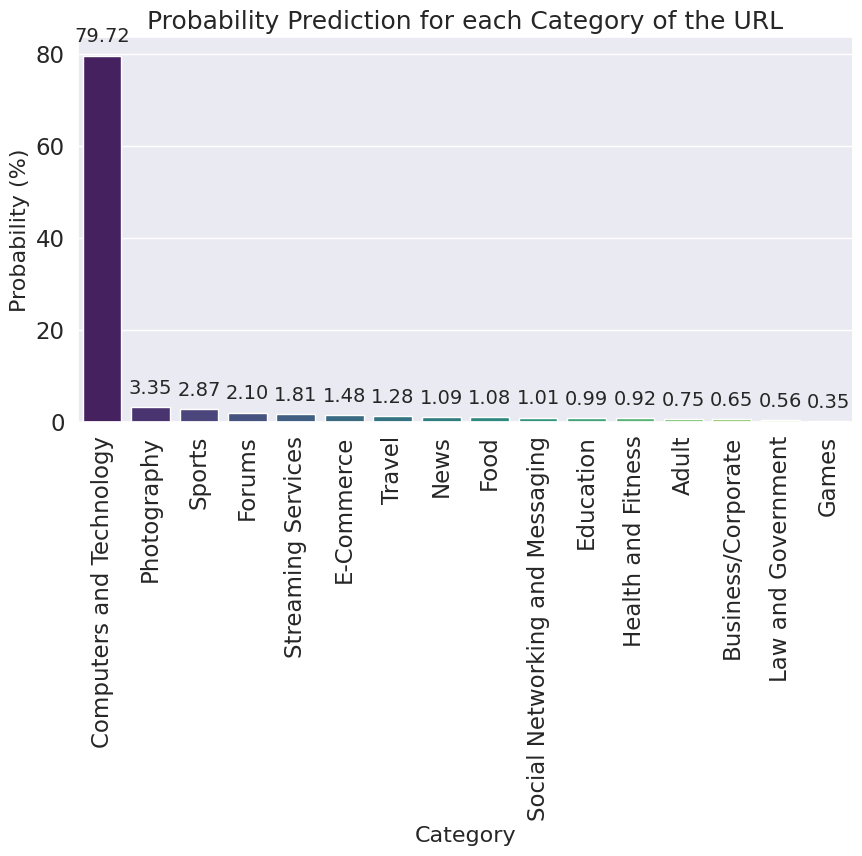

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'a' is a DataFrame with category names as the index and 'Probability' as a column
# Example structure of 'a':
#    Category        Probability
#    Business          30.5
#    Tech              40.7
#    Health            28.8

# Adjust the font scale and figure size
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 5))

# Get the index and values for plotting
categories = a.index.tolist()
probabilities = a['Probability'].values

# Create a bar plot
ax = sns.barplot(x=categories, y=probabilities, palette='viridis')

# Set title and labels
plt.title("Probability Prediction for each Category of the URL", fontsize=18)
plt.ylabel('Probability (%)', fontsize=16)
plt.xlabel('Category', fontsize=16)

# Adding the text labels on top of the bars
for rect, label in zip(ax.patches, probabilities):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 2, f'{label:.2f}', 
            ha='center', va='bottom', fontsize=14)

# Adjust x-axis labels rotation for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center')

# Display the plot
plt.show()


In [23]:
import joblib
# Save the fitted vectorizer
joblib.dump(fitted_vectorizer, 'fitted_vectorizer.joblib')

# Save the calibrated model
joblib.dump(m1, 'calibrated_svc_model.joblib')

['calibrated_svc_model.joblib']

decision trees, random forests, support vector machines, and neural networks